In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm
# from torchsde import sdeint_adjoint as sdeint

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
data = pd.read_csv('Data/gen.us.txt')['Close'].values

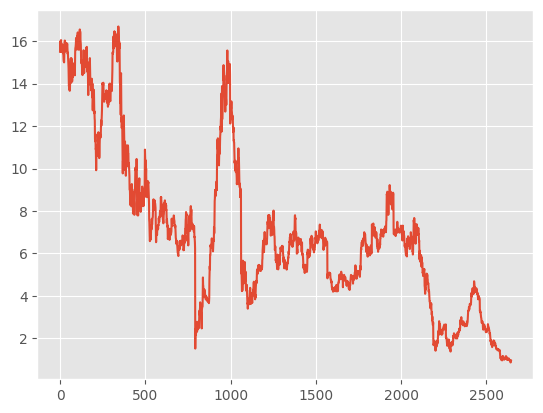

In [3]:
plt.plot(data)

plt.show()

In [4]:
data = np.log1p(data)

In [5]:
data.shape

(2645,)

In [6]:
scaler = MinMaxScaler((0, 1))

data = scaler.fit_transform(data.reshape(-1, 1)).T[0]

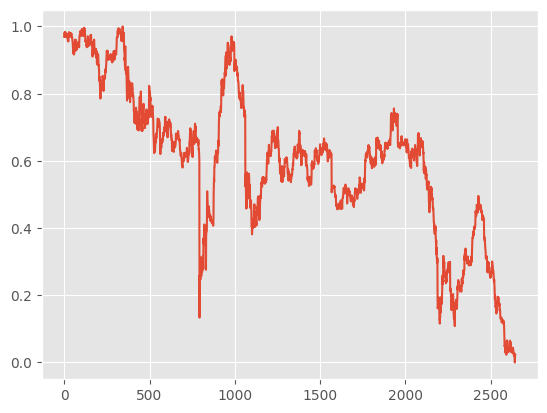

In [7]:
plt.plot(data)

In [8]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

In [9]:
# def split_series_adapted(x):
#     k = 2
#     train_sample = []

#     for _ in range(1, len(x)):
#         train_sample.append(x[:k])
#         k += 1

#     return train_sample

In [19]:
# z_train = split_series_adapted(z)

In [21]:
# data_train = split_series_adapted(data)

In [488]:
# np.r_[0., np.random.randn(10 - 1).cumsum()]

In [28]:
def create_setA(data: np.array) -> torch.Tensor:
    set_A = torch.zeros(len(data), len(data))
    k = 1
    for i in range(len(data)):
        set_A[i, :k] = torch.FloatTensor(data[:k])
        k += 1
    
    return set_A

In [29]:
set_A = create_setA(data)

In [30]:
# jac = jacobian(drift, (torch.FloatTensor([0]), u))
# torch.log(torch.abs(torch.linalg.det(jac[1][0].view(2645, 2645)) + 1e-8))

In [31]:
# jacobian(lambda x: sdeint(drift, diffusion, jump, dt, x, time_steps, h_dim), u)

# Baseline

### Data

In [10]:
def ornstein_uhlenbeck_process(n, m, mu):
    res = []
    theta = 1
    sigma = 0.5
    # mu = 0.0
    T = 1
    
    for j in range(m):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.random.normal(0, 0.1)
        dt = T/float(n)

        for t in range(n):
            x[t+1] = x[t] + theta*(mu - x[t]) * dt + sigma * np.sqrt(dt) * np.random.normal(loc=0, scale=1)
            time[t+1] = time[t] + dt

        res.append(x)
    
    return np.array(res).T

def dclProcess(N, M):
    T = 1
    theta = 1
    delta = 1

    Z1 = np.random.normal(0.0, 1.0, [M, N])
    X = np.zeros([M, N + 1])

    X[:, 0] = np.random.normal(0.0, 0.2, M)

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] - 1/theta * X[:,i] * dt + np.sqrt((1 - (X[:, i])**2)/(theta * (delta + 1))) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] >= 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] <= -1)[0], i+1] = -0.9999 
            
        time[i+1] = time[i] + dt

    return X.T

def merton_process(s0, xiP, muj, sigmaj, r, sigma, n, T):
        time = np.zeros(n + 1)
        dt = T/float(n)
        
        z = np.random.normal(0.0, 1.0, n + 1)
        zj = np.random.normal(muj, sigmaj, n + 1)
        poisson_distr = np.random.poisson(xiP * dt, n + 1)
        
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        
        s[0] = s0
        x[0] = np.log(s0)
        
        EeJ = np.exp(muj + 0.5 * sigmaj**2)

        for t in range(n):
            x[t+1] = x[t] + (r - xiP * (EeJ - 1) - 0.5 * sigma**2) * dt +\
                sigma * np.sqrt(dt) * z[t] + zj[t] * poisson_distr[t]
            
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return s
    
def geometric_BM(s0, mu, sigma, n, T):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.log(s0)
        dt = T/float(n)
        
        for t in range(n):
            x[t+1] = x[t] + (mu - (sigma**2)/2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return s

In [57]:
data = dclProcess(2000, 20).T
# data = merton_process(s0=1, xiP=3, muj=0, sigmaj=0.2, r=0.04, sigma=0.15, n=2000, T=1)
# data = geometric_BM(s0=1, mu=0.1, sigma=0.5, n=2000, T=1)

In [58]:
# data = np.log1p(data)

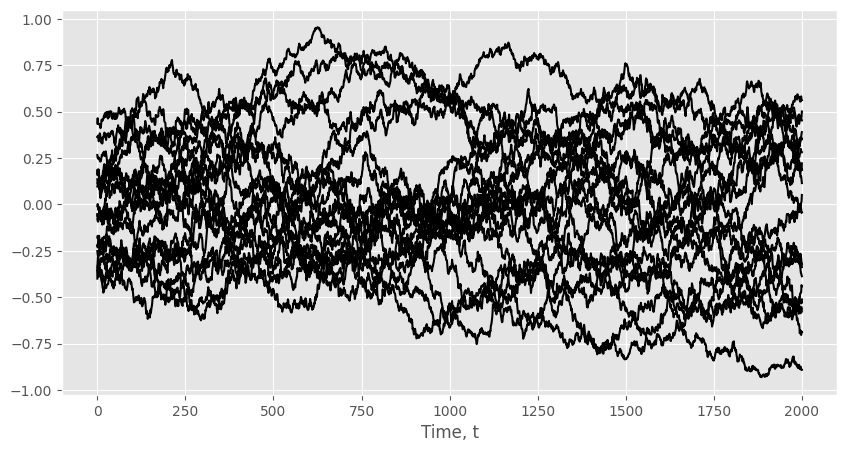

In [59]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data.T, color='black')

plt.xlabel('Time, t')
plt.show()

In [60]:
scaler = MinMaxScaler((0, 1))
data = scaler.fit_transform(data)
# data = scaler.fit_transform(data.reshape(-1, 1)).reshape(1, -1)

In [61]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

In [62]:
data_tensor

tensor([[0.4155, 0.3764, 0.4077,  ..., 0.7377, 0.7379, 0.7659],
        [0.0525, 0.0000, 0.0000,  ..., 0.9144, 0.9362, 0.9579],
        [0.4661, 0.4539, 0.4625,  ..., 0.7999, 0.8057, 0.8070],
        ...,
        [0.6928, 0.6398, 0.6790,  ..., 0.2515, 0.2466, 0.2610],
        [0.0714, 0.0917, 0.1338,  ..., 0.1265, 0.1429, 0.1398],
        [0.2108, 0.1833, 0.2170,  ..., 0.0000, 0.0000, 0.0000]])

In [10]:
def real_data_loading(data: np.array, seq_len):
    ori_data = data[::]
    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len + 1):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data

In [15]:
data_windows = real_data_loading(data.reshape(-1, 1), 500)

In [17]:
dataloader = DataLoader(data_windows, batch_size=64, shuffle=True)

In [18]:
# data_tensor = torch.diff(data_tensor)

In [19]:
# torch.cumsum(torch.cat([data0.unsqueeze(0), data_tensor], dim=0), dim=0)

In [20]:
next(iter(dataloader)).size()

torch.Size([64, 500, 1])

### Modules

In [258]:
n = len(data)

In [11]:
class Phi(nn.Module):
    def __init__(self, z_dim, h_dim, data_dim):
        super(Phi, self).__init__()
        
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.data_dim = data_dim
        
        self.model = nn.Sequential(nn.Linear(self.z_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.h_dim))
        
        self.linear = nn.Sequential(nn.Linear(self.data_dim, self.h_dim),
                                    nn.ReLU(),
                                    nn.Linear(self.h_dim, self.h_dim))
        
    def forward(self, x, x0):
        out = self.model(x)
        out_x0 = self.linear(x0)
        
        return out + out_x0


class Drift(nn.Module):
    def __init__(self, h_dim):
        super(Drift, self).__init__()

        self.h_dim = h_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.proj = nn.Linear(2**7, self.h_dim)

    def forward(self, t, x):
        out_x = self.model(x)
        out_t = self.t_nn(t)
        out = torch.cat([out_t.view(-1, 2**6), out_x], axis=1)
        out = self.proj(out)
        
        return out
    
class Diffusion(nn.Module):
    def __init__(self, h_dim, w_dim):
        super(Diffusion, self).__init__()

        self.h_dim = h_dim
        self.w_dim = w_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.proj = nn.Linear(2**7, self.h_dim * self.w_dim)

    def forward(self, t, x):
        out_x = self.model(x)
        out_t = self.t_nn(t)
        out = torch.cat([out_t.view(-1, 2**6), out_x], axis=1)
        out = self.proj(out)
        
        if self.w_dim == 1:
            return out
        
        else:
            return out.view(self.h_dim, self.w_dim)
    
class Jump(nn.Module):
    def __init__(self, h_dim):
        super(Jump, self).__init__()

        self.h_dim = h_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.proj = nn.Linear(2**7, self.h_dim)

    def forward(self, t, x):
        out_x = self.model(x)
        out_t = self.t_nn(torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1))
        out = torch.cat([out_t.view(1, 2**6), out_x], axis=1)
        out = self.proj(out)
        
        return out  
    
class Mu_V(nn.Module):
    def __init__(self, h_dim, h_dim_v, data_dim):
        super(Mu_V, self).__init__()

        self.h_dim = h_dim
        self.h_dim_v = h_dim_v
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.a_nn = nn.Sequential(nn.Linear(self.data_dim, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.proj = nn.Linear(3 * 2**6, self.h_dim_v)

    def forward(self, t, x, a):
        out_x = self.model(x)
        out_t = self.t_nn(torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1))
        out_a = self.a_nn(a)
        out = torch.cat([out_t.view(1, 2**6), out_x, out_a.view(1, 2**6)], axis=1)
        out = self.proj(out)
        
        return out
    
class Sigma_V(nn.Module):
    def __init__(self, h_dim, h_dim_v, data_dim):
        super(Sigma_V, self).__init__()

        self.h_dim = h_dim
        self.h_dim_v = h_dim_v
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.a_nn = nn.Sequential(nn.Linear(self.data_dim, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.proj = nn.Linear(3 * 2**6, self.h_dim_v)

    def forward(self, t, x, a):
        out_x = self.model(x)
        out_t = self.t_nn(torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1))
        out_a = self.a_nn(a)
        out = torch.cat([out_t.view(1, 2**6), out_x, out_a.view(1, 2**6)], axis=1)
        out = self.proj(out)
        
        return out
    
class Operator_F(nn.Module):
    def __init__(self, h_dim, data_dim):
        super(Operator_F, self).__init__()

        self.h_dim = h_dim
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Sigmoid(),
                                #    nn.BatchNorm1d(n),
                                   nn.Linear(2**7, 2**7),
                                   nn.Sigmoid(),
                                #    nn.BatchNorm1d(n),
                                   nn.Linear(2**7, self.data_dim),
                                   nn.Sigmoid())
        
        # self.rnn = nn.LSTM(h_dim, h_dim, 5, bidirectional=False)

    def forward(self, x):
        # out, _ = self.rnn(x)
        out = self.model(x)
        return out
    
class Operator_G(nn.Module):
    def __init__(self, h_dim, data_dim):
        super(Operator_G, self).__init__()

        self.h_dim = h_dim
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.data_dim))

    def forward(self, x):
        out = self.model(x)
        return out

In [12]:
class JSD(nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p, q = F.softmax(p.view(-1, p.size(-1))), F.softmax(q.view(-1, q.size(-1)))
        m = (0.5 * (p + q)).log()
        
        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))

In [13]:
def calc_windows_eq_size(data, size=10):
    k = len(data)//size
    windows = []

    for i in range(size):
        windows.append(data[i*k : (i+1)*k])
        
    windows = np.mean(np.array(windows), 1)
    
    return torch.FloatTensor(windows)

In [14]:
def sdeint(drift, diffusion, dt, x0, n, h_dim, w_dim):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    solution = []
    solution.append(x0)
    t = torch.FloatTensor([0])
    
    if t.size(0) != x0.size(0):
        t = t.repeat(x0.size(0)).view(-1, 1)
        
        for i in range(n - 1):
            t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=1)
            x_next = solution[i] + drift(t_emb, solution[i]) * dt + diffusion(t_emb, solution[i]) * wiener_process[i] 
            # x_next = solution[i] + drift(t, solution[i]) * dt + torch.matmul(diffusion(t, solution[i]), wiener_process[i].T).T
            t = t + dt
            solution.append(x_next)
            
    else:
        for i in range(n - 1):
            t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1)
            x_next = solution[i] + drift(t_emb, solution[i]) * dt + diffusion(t_emb, solution[i]) * wiener_process[i] 
            # x_next = solution[i] + drift(t, solution[i]) * dt + torch.matmul(diffusion(t, solution[i]), wiener_process[i].T).T
            t = t + dt
            solution.append(x_next)
        
    if h_dim == 1:
        solution = torch.FloatTensor(solution).view(-1, 1)
        # solutions = solutions + solution
        
    else:
        solution = torch.stack(solution, 1).squeeze()
        # solutions = solutions + solution
            
    return solution

def sdeint_V(drift, diffusion, dt, x0, n, h_dim, set_A):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
        
    solution = []
    solution.append(x0)
    t = torch.FloatTensor([0])
    
    for i in range(n - 1):
        x_next = solution[i] + drift(t, solution[i], set_A[i]) * dt + diffusion(t, solution[i], set_A[i]) * wiener_process[i] 
        t = t + dt
        solution.append(x_next)
        
    if h_dim == 1:
        solution = torch.FloatTensor(solution).view(-1, 1)
        
    else:
        solution = torch.stack(solution, 1).squeeze()
            
    return solution

def sdeint_jump(drift, diffusion, jump, dt, x0, n, h_dim):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    
    solution = []
    solution.append(x0)
    t = torch.FloatTensor([0])
    xiP = 1
    poisson_distr = torch.FloatTensor(np.random.poisson(xiP * dt, size=(n, 1, h_dim)))
    # muj = 0
    # sigmaj = 1
    # zJ = np.random.normal(muj, sigmaj, n + 1)
    
    for i in range(n - 1):
        x_next = solution[i] + drift(t, solution[i]) * dt + diffusion(t, solution[i]) * wiener_process[i] +\
            jump(t, solution[i]) * poisson_distr[i]
            
        t = t + dt
        solution.append(x_next)
        
    if h_dim == 1:
        solution = torch.FloatTensor(solution).view(-1, 1)
        
    else:
        solution = torch.stack(solution, 1).squeeze()
            
    return solution

In [15]:
def sdeint_inverse(drift, diffusion, dt, x, n, h_dim, w_dim):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    # solution = torch.zeros(n, h_dim)
    # solution[-1] = x
    
    t = torch.FloatTensor([1])
    if t.size(0) != x.size(0):
        t = t.repeat(x.size(0)).view(-1, 1)
        solution = torch.zeros(n, x.size(0), h_dim)
        solution[-1] = x
        
        for i in range(n-1, 0, -1):
            t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=1)
            x_prev = solution[i] - drift(t_emb, solution[i]) * dt - diffusion(t_emb, solution[i]) * wiener_process[i]
            # x_prev = solution[i].view(1, h_dim) - drift(t, solution[i].view(1, h_dim)) * dt - torch.matmul(diffusion(t, solution[i].view(1, h_dim)), wiener_process[i].T).T
            t = t - dt
                
            solution[i-1] = x_prev
    
    else:
        solution = torch.zeros(n, h_dim)
        solution[-1] = x
        
        for i in range(n-1, 0, -1):
            t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1)
            x_prev = solution[i].view(1, h_dim) - drift(t_emb, solution[i].view(1, h_dim)) * dt - diffusion(t_emb, solution[i].view(1, h_dim)) * wiener_process[i]
            # x_prev = solution[i].view(1, h_dim) - drift(t, solution[i].view(1, h_dim)) * dt - torch.matmul(diffusion(t, solution[i].view(1, h_dim)), wiener_process[i].T).T
            t = t - dt
                
            solution[i-1] = x_prev
            
    return solution[0]

def sdeint_jump_inverse(drift, diffusion, jump, dt, x, n, h_dim):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    xiP = 1
    poisson_distr = torch.FloatTensor(np.random.poisson(xiP * dt, size=(n, 1, h_dim)))
    
    solution = torch.zeros(n, h_dim)
    solution[-1] = x
    
    t = torch.FloatTensor([1])

    for i in range(n-1, 0, -1):
        x_prev = solution[i].view(1, h_dim) - drift(t, solution[i].view(1, h_dim)) * dt - diffusion(t, solution[i].view(1, h_dim)) * wiener_process[i] -\
            jump(t, solution[i].view(1, h_dim)) * poisson_distr[i]
        t = t - dt
            
        solution[i-1] = x_prev
            
    return solution[0]

## Train

In [16]:
# z_dim = 15
# h_dim = 64
# data_dim = 1
# dt = torch.FloatTensor([1/len(data_tensor)])

# phi = Phi(z_dim, h_dim, data_dim + 10)
# drift = Drift(h_dim)
# diffusion = Diffusion(h_dim)
# jump = Jump(h_dim)
# f = Operator_F(h_dim, data_dim)
# g = Operator_G(h_dim, data_dim)

# optim_phi = optim.Adam(phi.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_drift = optim.Adam(drift.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_diffusion = optim.Adam(diffusion.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_jump = optim.Adam(jump.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_f = optim.Adam(f.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_g = optim.Adam(g.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)

In [426]:
# epochs = tqdm(range(50))
# char_series_for_x0 = calc_windows_eq_size(data)
# # torch.autograd.set_detect_anomaly(False)
# # distr = MultivariateNormal(torch.mean(torch.diff(data_tensor, 2)) * torch.eye(len(data) - 2), torch.std(torch.diff(data_tensor, 2)) * torch.eye(len(data) - 2))

# for _ in epochs:
#     # loss = nn.MSELoss()
#     loss2 = nn.MSELoss()
#     jsd = JSD()
#     # nll = nn.GaussianNLLLoss()

#     noise = torch.mean(torch.FloatTensor(dclProcess(10, z_dim)), dim=0)
#     dt = torch.FloatTensor([1/len(data_tensor)])
#     char_x0 = torch.cat([data0.unsqueeze(0).unsqueeze(0), char_series_for_x0.unsqueeze(0)], axis=1)
#     xi0 = phi(noise, char_x0)

#     xi = sdeint(drift, diffusion, jump, dt, xi0, len(data_tensor), h_dim)
#     # x = f(torch.cat([xi, data_tensor.view(-1, 1)], dim=1))
#     x = f(xi)

    # criterion = 0.8 * jsd(data_tensor, x.view(-1)) + 0.2 * torch.abs(f(xi0).squeeze() - data0)**2
    # criterion = jsd(data_tensor, x.view(-1)) + torch.abs(f(torch.cat([xi0, data0.view(-1, 1)], dim=1)).squeeze() - data0)**2 
    # criterion = 0.4 * nll(torch.diff(x.view(-1), 1), torch.diff(data_tensor, 1), torch.ones_like(torch.diff(data_tensor, 1))) +\
        # 0.1 * torch.abs(f(xi0).squeeze() - data0)**2 + 0.1 * jsd(data_tensor, x.view(-1)) + 0.4 * loss2(data_tensor, x.view(-1))
    # criterion = torch.abs(f(torch.cat([xi0, data0.view(-1, 1)], dim=1)).squeeze() - data0)**2 + loss2(data_tensor, x.view(-1))
    # criterion = jsd(data_tensor, x.view(-1)) + torch.abs(f(xi0) - data0)**2 + loss2(data_tensor, x.view(-1))
        
 
    # optim_phi.zero_grad()
    # optim_drift.zero_grad()
    # optim_diffusion.zero_grad()
    # optim_f.zero_grad()
    # # optim_jump.zero_grad()
    # # optim_g.zero_grad()

    # criterion.backward()
    
    # optim_phi.step()
    # optim_drift.step()
    # optim_diffusion.step()
    # optim_f.step()
    # # optim_jump.step()
    # # optim_g.step()

    # epochs.set_description(f'Loss {criterion.item()}')

## Flows + NSDE

In [160]:
# data_tensor = torch.randn(2000).view(1, -1) + 3
# data0 = data_tensor[0][0]

In [263]:
class DiffMap(nn.Module):
    def __init__(self, hidden, in_size, out_size):

        super(DiffMap, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        

        self.sig_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        self.mu_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        base_mu, base_cov = torch.zeros(out_size), torch.eye(out_size)
        self.base_dist = MultivariateNormal(base_mu, base_cov)

    def forward(self, x):
        sig = self.sig_net(x)
        z = x * torch.exp(sig) + self.mu_net(x)

        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)

        return z, log_pz, log_jacob

    def inverse(self, z):
        sig_in = self.sig_net(z)
        x = (z - self.mu_net(z)) * torch.exp(-sig_in)
        
        return x

class Flow(nn.Module):
    def __init__(self, hidden, n_flows, in_size, out_size):
        super(Flow, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size

        self.bijections = nn.ModuleList(
            [DiffMap(hidden, self.in_size, self.out_size) for _ in range(n_flows)]
        )

    def forward(self, x):
        log_jacobs = []

        for bijection in self.bijections:

            x, log_pz, lj = bijection(x)

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):

        for bijection in reversed(self.bijections):

            z = bijection.inverse(z)

        return z.detach().numpy()
    
    def fit(self, X, epochs=200, learning_rate=3e-4):
        
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

        losses = []
        
        epochs = tqdm(range(epochs))

        for _ in epochs:
            z, log_pz, log_jacob = self.forward(X)
            loss = (-log_pz - log_jacob).mean()

            losses.append(loss.detach().numpy())

            optim.zero_grad()
            loss.backward()
            optim.step()
            scheduler.step()

            epochs.set_description(f'Loss: {round(loss.item(), 4)}')

        # return losses
    
    def sample(self, n_samples):
        mu, cov = torch.zeros(self.out_size), torch.eye(self.out_size)
        p_Z = MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))

        X_sample = self.inverse(z)

        return X_sample

In [18]:
data_tensor = data_tensor.view(1, -1)

In [19]:
z_dim = 15
h_dim = len(data_tensor[0])
h_dim_v = 1
w_dim = 1
data_dim = len(data_tensor[0])
time_steps = 100
dt = torch.FloatTensor([1/time_steps])

phi = Phi(z_dim, 1, 1 + 10)
drift = Drift(h_dim)
diffusion = Diffusion(h_dim, w_dim)
jump = Jump(h_dim)
f = Operator_F(h_dim, h_dim)
mu_v = Mu_V(1, h_dim_v, data_dim)
sigma_v = Sigma_V(1, h_dim_v, data_dim)

optim_phi = optim.Adam(phi.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_drift = optim.Adam(drift.parameters(), lr=1e-3)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=1e-3)
optim_jump = optim.Adam(jump.parameters(), lr=1e-3)
optim_f = optim.Adam(f.parameters(), lr=1e-3, betas=(0.9, 0.999), amsgrad=True)
optim_mu_v = optim.Adam(mu_v.parameters(), lr=1e-3)
optim_sigma_v = optim.Adam(sigma_v.parameters(), lr=1e-3)

In [143]:
nsde_flow = Flow(128, 10, h_dim, h_dim)

nsde_flow.fit(data_tensor, epochs=500)

Loss: -11260.6045: 100%|██████████| 500/500 [00:29<00:00, 17.11it/s]


In [144]:
u = nsde_flow.forward(data_tensor)[0].detach()

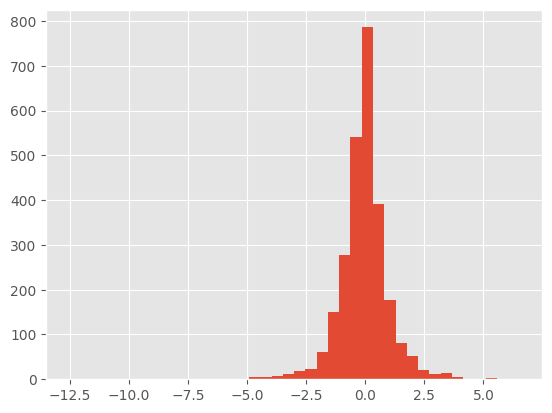

In [145]:
plt.hist(u[0], bins=40)
plt.show()

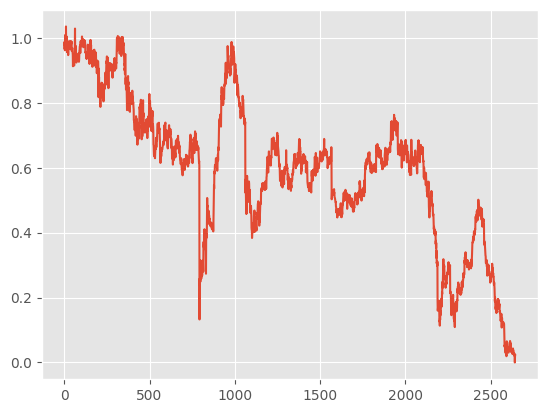

In [146]:
plt.plot(torch.FloatTensor(nsde_flow.sample(1)).numpy()[0])

In [20]:
u = data_tensor

In [21]:
epochs = tqdm(range(100))

char_series_for_x0 = calc_windows_eq_size(data)
char_x0 = torch.cat([data0.unsqueeze(0).unsqueeze(0), char_series_for_x0.unsqueeze(0)], axis=1)

base_mu, base_cov = torch.zeros(h_dim), torch.eye(h_dim)
distr = MultivariateNormal(base_mu, base_cov)

# torch.autograd.set_detect_anomaly(False)
for _ in epochs:
    mse = nn.MSELoss()
    # loss2 = nn.MSELoss()
    jsd = JSD()

    # noise = torch.mean(torch.FloatTensor(dclProcess(10, z_dim)), dim=0)
 
    
    # v0 = phi(torch.randn(z_dim), char_x0)
    # v_solution = sdeint_V(mu_v, sigma_v, dt, v0, data_dim, h_dim_v, set_A)
    
    xi0 = u

    xi = sdeint(drift, diffusion, dt, xi0, time_steps, h_dim, w_dim)
    # x = f(xi)

    # criterion = jsd(data_tensor, x.view(-1)) + torch.abs(f(torch.cat([xi0, data0.view(-1, 1)], dim=1)).squeeze() - data0)**2 
    # criterion = 0.4 * nll(torch.diff(x.view(-1), 1), torch.diff(data_tensor, 1), torch.ones_like(torch.diff(data_tensor, 1))) +\
        # 0.1 * torch.abs(f(xi0).squeeze() - data0)**2 + 0.1 * jsd(data_tensor, x.view(-1)) + 0.4 * loss2(data_tensor, x.view(-1))
    # criterion = torch.abs(f(torch.cat([xi0, data0.view(-1, 1)], dim=1)).squeeze() - data0)**2 + loss2(data_tensor, x.view(-1))
    # criterion = jsd(data_tensor, x.view(-1)) + torch.abs(f(xi0) - data0)**2 + loss2(data_tensor, x.view(-1))
    
    if u.size(0) == 1:
        z = torch.randn(h_dim).view(1, -1)
        x0 = sdeint_inverse(drift, diffusion, dt, z, time_steps, h_dim, w_dim).detach().view(1, -1)
        # + jsd(x0[0], u[0])
        s_tilde = f(x0[0].view(1, -1))
        
        
        criterion = - torch.mean(distr.log_prob(xi[-1])) + mse(s_tilde[0], u[0])
    
    else:
        z = torch.randn(20, h_dim)
        x0 = sdeint_inverse(drift, diffusion, dt, z, time_steps, h_dim, w_dim).detach()
        s_tilde = f(x0[0])
        
        
        criterion = - torch.mean(distr.log_prob(xi[-1])) + mse(s_tilde, u)
 
    
    optim_drift.zero_grad()
    optim_diffusion.zero_grad()
    # optim_phi.zero_grad()
    # optim_mu_v.zero_grad()
    # optim_sigma_v.zero_grad()
    optim_f.zero_grad()
    # optim_jump.zero_grad()
    # optim_g.zero_grad()

    criterion.backward()
    
    
    optim_drift.step()
    optim_diffusion.step()
    # optim_phi.step()
    # optim_mu_v.step()
    # optim_sigma_v.step()
    optim_f.step()
    # optim_jump.step()
    # optim_g.step()

    epochs.set_description(f'Loss {criterion.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Loss 2431.029052734375: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


In [22]:
# plt.plot(v_solution)

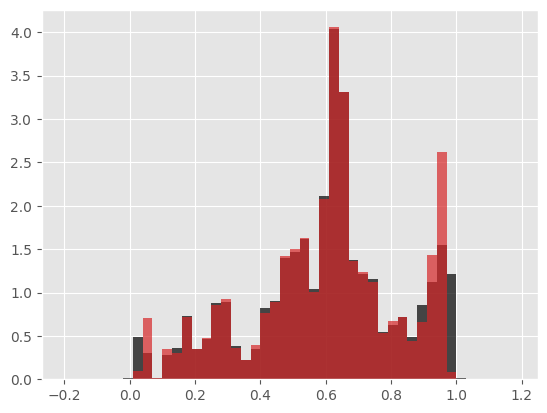

In [26]:
xi0 = u

if xi0.size(0) == 1:
    x = sdeint(drift, diffusion, dt, xi0, time_steps, h_dim, w_dim)
    x_inv = f(sdeint_inverse(drift, diffusion, dt, x[-1].view(1, -1), time_steps, h_dim, w_dim).detach().view(1, -1))


    plt.hist(u, color='black', bins=np.arange(-0.2, 1.2, 0.03), density=True, alpha=0.7)
    plt.hist(x_inv.detach().cpu().numpy()[-1], color='tab:red', bins=np.arange(-0.2, 1.2, 0.03), density=True, alpha=0.7)
    # plt.hist(x.detach().cpu().numpy()[0], color='tab:blue', bins=40, density=True)
    plt.show()

else:
    x = sdeint(drift, diffusion, dt, xi0, time_steps, h_dim, w_dim)
    x_inv = f(sdeint_inverse(drift, diffusion, dt, x[-1], time_steps, h_dim, w_dim).detach())


    plt.hist(u, bins=np.arange(-1e-5, 1+1e-5, 0.2), density=True, alpha=0.7)
    # plt.hist(x_inv.detach().cpu().numpy()[-1], bins=np.arange(-0.2, 1.2, 0.03), density=True, alpha=0.7)
    # plt.hist(x.detach().cpu().numpy()[0], color='tab:blue', bins=40, density=True)
    plt.show()

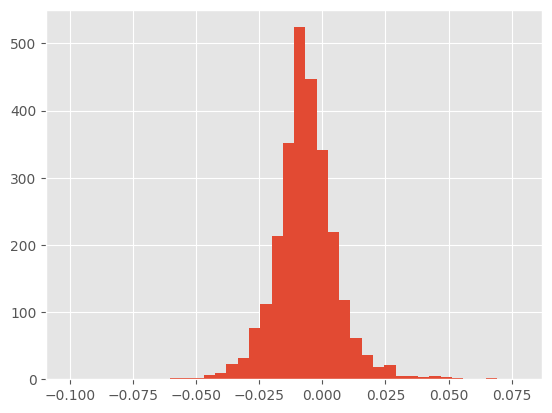

In [ ]:
plt.hist(x[-1].detach().numpy(), bins=40)
plt.show()

In [ ]:
x_array = []
for i in range(10):
    z = torch.randn(h_dim) * x[-1].std() + x[-1].mean()
    x0 = f(sdeint_inverse(drift, diffusion, dt, z, time_steps, h_dim, w_dim).detach().view(1, -1)).detach()
    x_array.append(x0)

In [ ]:
# synth_data = nsde_flow.inverse(x0)[0]

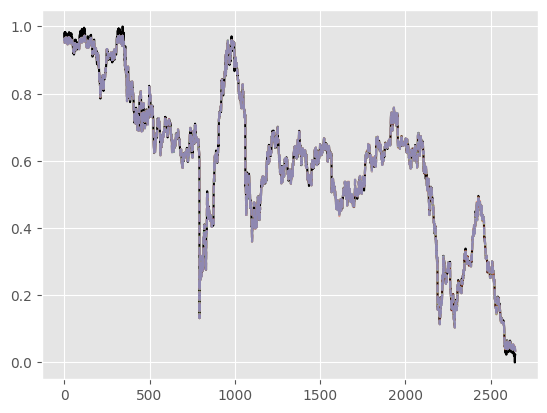

In [ ]:
plt.plot(data, color='black', label='Real')
# plt.plot(x0[0], color='tab:red', label='Synth', alpha=0.5)

for i in range(10):
    plt.plot(x_array[i][0], '--', label='Synth', alpha=0.5)

plt.legend
plt.show()

In [85]:
next(iter(diffusion.parameters()))

Parameter containing:
tensor([[-0.0078, -0.0159, -0.0135,  ...,  0.0039, -0.0098,  0.0091],
        [-0.0244,  0.0143, -0.0241,  ...,  0.0145,  0.0155, -0.0197],
        [ 0.0240,  0.0116,  0.0188,  ...,  0.0253, -0.0021,  0.0122],
        ...,
        [ 0.0017, -0.0044,  0.0085,  ..., -0.0037,  0.0066,  0.0103],
        [ 0.0134,  0.0056,  0.0083,  ...,  0.0044,  0.0225,  0.0034],
        [-0.0089, -0.0092,  0.0083,  ...,  0.0062,  0.0003, -0.0105]],
       requires_grad=True)

In [86]:
next(iter(drift.parameters()))

Parameter containing:
tensor([[-0.0016,  0.0003,  0.0086,  ...,  0.0046,  0.0019,  0.0079],
        [ 0.0040,  0.0143, -0.0027,  ..., -0.0057,  0.0170,  0.0010],
        [ 0.0039,  0.0111,  0.0063,  ..., -0.0041, -0.0024, -0.0052],
        ...,
        [ 0.0192, -0.0141, -0.0087,  ..., -0.0191, -0.0040,  0.0050],
        [ 0.0030,  0.0010, -0.0164,  ..., -0.0193, -0.0266, -0.0418],
        [ 0.0012, -0.0047, -0.0016,  ...,  0.0075, -0.0022,  0.0012]],
       requires_grad=True)

In [414]:
next(iter(jump.parameters()))

Parameter containing:
tensor([[-0.0153,  0.0016,  0.0120,  ..., -0.0183, -0.0015,  0.0089],
        [-0.0021, -0.0025, -0.0022,  ...,  0.0013,  0.0124,  0.0137],
        [ 0.0020, -0.0162,  0.0146,  ..., -0.0024,  0.0165,  0.0127],
        ...,
        [ 0.0175, -0.0157,  0.0159,  ..., -0.0045,  0.0180,  0.0154],
        [ 0.0145,  0.0143, -0.0047,  ..., -0.0185,  0.0029, -0.0022],
        [-0.0118,  0.0182, -0.0039,  ..., -0.0107,  0.0162, -0.0067]],
       requires_grad=True)

In [49]:
phi.eval()
drift.eval()
diffusion.eval()
# jump.eval()
f.eval()

Operator_F(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2000, bias=True)
  )
)

In [159]:
# k = 20
# windows = []

# for i in range(len(data)//k):
#     windows.append(data[i*k : (i+1)*k])
    
# windows = np.array(windows)

# dataloader = DataLoader(windows.reshape(-1, 20, 1), batch_size=20, shuffle=True)

In [160]:
# epochs = tqdm(range(200))
# # torch.autograd.set_detect_anomaly(False)

# for _ in epochs:
#     # loss = nn.MSELoss()
#     loss2 = nn.MSELoss()
#     jsd = JSD()
#     nll = nn.GaussianNLLLoss()
    
#     #Batch 
#     # ------------------------
#     for data_batch in dataloader:
#         # x_tensor = torch.FloatTensor([])
#         criterion_array = torch.tensor(0.0)
        
#         for data_tensor in data_batch:

#             noise = torch.FloatTensor(dclProcess(1, z_dim))[1]
#             dt = torch.FloatTensor([1/len(data_tensor)])
            
#             xi0 = phi(noise, data0.unsqueeze(0)).unsqueeze(0)
            
            # print(next(iter(phi.parameters())))

    #         xi = sdeint(drift, diffusion, dt, xi0, len(data_tensor), h_dim)
    #         x = f(xi)

    #         # x_tensor = torch.cat([x_tensor, x], dim=0)
    
    #         # criterion = 0.3 * nll(torch.diff(x, 1), torch.diff(data_tensor, 1), torch.ones_like(torch.diff(data_tensor, 1))) +\
    #         criterion = 0.3 * torch.abs(f(xi0).squeeze() - data0)**2 + 0.4 * loss2(data_tensor, torch.tensor(x, dtype=float))
        
    #         criterion_array = criterion_array + criterion
            
    #     criterion = criterion_array/64
    # # -------------------------

    #     optim_phi.zero_grad()
    #     optim_drift.zero_grad()
    #     optim_diffusion.zero_grad()
    #     f.zero_grad()
    #     # g.zero_grad()

    #     criterion.backward()
        
    #     optim_phi.step()
    #     optim_drift.step()
    #     optim_diffusion.step()
    #     optim_f.step()
    #     # optim_g.step()

    # epochs.set_description(f'Loss {criterion.item()}')

In [50]:
def sample(z_dim, h_dim, phi, drift, diffusion, f, g, data, data0):
    
    noise = torch.mean(torch.FloatTensor(dclProcess(10, z_dim)), dim=0)
    char_x0 = torch.cat([data0.unsqueeze(0).unsqueeze(0), char_series_for_x0.unsqueeze(0)], axis=1)
    xi0 = phi(noise, char_x0)

    x = sdeint(drift, diffusion, jump, dt, xi0, len(data), h_dim)
    # x = f(torch.cat([x, data_tensor.view(-1, 1)], dim=1))
    x = f(x)
    
    return x.detach().cpu().numpy()

In [51]:
x_array = []
for i in range(10):
    gen_path = sample(z_dim, h_dim, phi, drift, diffusion, f, g, data, data0)
    # gen_path = torch.cumsum(torch.cat([data0.unsqueeze(0), torch.FloatTensor(gen_path).view(1, -1).squeeze()], dim=0), dim=0)
    x_array.append(gen_path)
    
x_array = np.array(x_array)
x_array = x_array.T[0]

NameError: name 'char_series_for_x0' is not defined

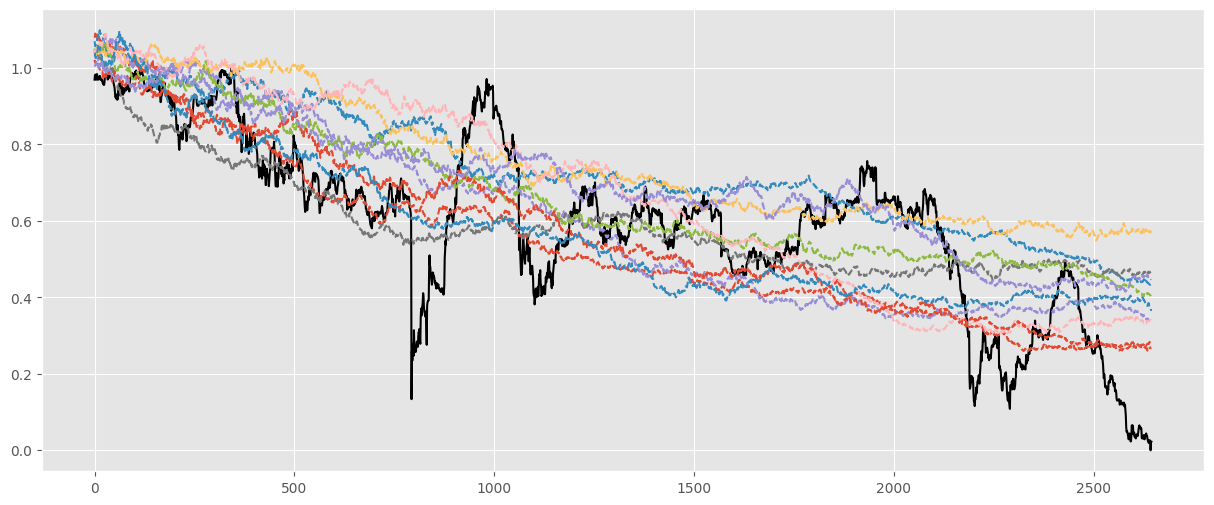

In [166]:
plt.subplots(figsize=(15, 6), dpi=100)

plt.plot(data[:], color='black')
plt.plot(x_array[:], '--')

plt.show()

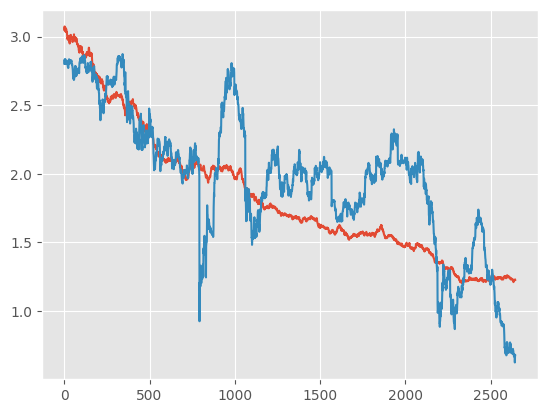

In [172]:
plt.plot(scaler.inverse_transform(x_array.T[0].reshape(-1, 1)))
plt.plot(scaler.inverse_transform(data.reshape(-1, 1)))

In [26]:
def log_normal_pdf(x, mean, var):
    x_norm = (x - mean)**2 / (var + 1e-5)
    const = torch.from_numpy(np.array([2. * np.pi])).float()
    const = torch.log(const)
    logvar = torch.log(var)
    pdf = -.5 * (const + logvar + x_norm)
    
    return pdf

def calculate_log_likelihood(sample_paths, real_path):
    mean = torch.mean(torch.diff(sample_paths, dim=1), dim=0) 
    var = torch.var(torch.diff(sample_paths, dim=1), dim=0)
    x = torch.diff(real_path)
    log_pdf = log_normal_pdf(x, mean, var + 1e-5)
    
    return log_pdf.mean()

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

In [ ]:
x = torch.FloatTensor([0, 1, 2, 0])
xhat = torch.FloatTensor([[0, 2, 1, 0], [0, 1, 2, 1]])

In [140]:
sts.norm.logpdf(x)

array([-0.91893853, -1.41893853, -2.91893853, -0.91893853])

In [135]:
log_normal_pdf(x, torch.FloatTensor([0]), torch.FloatTensor([1]))

tensor([-0.9189, -1.4189, -2.9189, -0.9189])

In [142]:
calculate_log_likelihood(xhat, x)

tensor(-8332.5000)

In [ ]:
       #likelihood loss
        #------------------------
        # x_array = []
        # for i in range(50):
        #     xi = sdeint(drift, diffusion, dt, xi0, len(data), h_dim)
        #     x = f(xi)
            
        #     x_array.append(x)
            
        # x = torch.stack(x_array, 1).view(1, 50, -1).squeeze()
        
        # criterion2 = - calculate_log_likelihood(x, data_tensor)
        

        # reg_lambda = 0.1
        # reg = torch.tensor(0.) 
        
        # for param in f.parameters():
        #     reg += torch.norm(param, 1)
            
        # criterion2 += reg_lambda * reg
        #------------------------

In [173]:
class NSDEFunction(nn.Module):
    def __init__(self, hidden, in_size, out_size):

        super(NSDEFunction, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        

        self.sig_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        self.mu_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        base_mu, base_cov = torch.zeros(out_size), torch.eye(out_size)
        self.base_dist = MultivariateNormal(base_mu, base_cov)

    def forward(self, x):
        sig = self.sig_net(x)
        z = x * torch.exp(sig) + self.mu_net(x)

        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)

        return z, log_pz, log_jacob

    def inverse(self, z):
        sig_in = self.sig_net(z)
        x = (z - self.mu_net(z)) * torch.exp(-sig_in)

        return x

In [77]:
z_dim = 15
h_dim = 1
data_dim = 1
dt = torch.FloatTensor([1/len(data_tensor)])

phi = Phi(z_dim + len(data_tensor), h_dim, data_dim + 10)
drift = Drift(h_dim)
diffusion = Diffusion(h_dim)
jump = Jump(h_dim)
f = Operator_F(h_dim, data_dim)
g = Operator_G(h_dim, data_dim)

optim_phi = optim.Adam(phi.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_drift = optim.Adam(drift.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_jump = optim.Adam(jump.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_f = optim.Adam(f.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_g = optim.Adam(g.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)

In [121]:
def sdeint_inverse(drift, diffusion, jump, dt, x, n, h_dim):
    solutions = torch.zeros(n, h_dim)
    
    if h_dim != 1:
        
        for j in range(1):
            solution = []
            solution.append(x0)
            t = torch.FloatTensor([0])
            # xiP = 10
            # poisson_distr = np.random.poisson(xiP * dt, n + 1)
            # zJ = np.random.normal(muj, sigmaj, n + 1)
        
            for i in range(n - 1):
                x_next = solution[i] + drift(t, solution[i].view(1, -1)) * dt +\
                    diffusion(t, solution[i].view(1, -1)) * torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(1, h_dim)))
                    # jump(t, solution[i].view(1, -1)) * poisson_distr[i]
                    
                t = t + dt
                    
                solution.append(x_next)
                
            solution = torch.stack(solution, 1).squeeze()
            
            solutions = solutions + solution
            
        return torch.div(solutions, 1)
    
    else:
        for j in range(1):
            # solution = []
            # solution.append(x[-1])
            solution = torch.zeros(n)
            solution[-1] = x[-1]
            
            t = torch.FloatTensor([1])
        
            for i in range(n-1, 0, -1):
                # x_next = solution[i] + drift(t, solution[i]) * dt +\
                #     diffusion(t, solution[i]) * torch.sqrt(dt) * torch.FloatTensor([np.random.normal(0, 1)])
                # print(t, solution[i].unsqueeze(0))
                x_prev = solution[i] - drift(t, solution[i].view(-1, 1)) * dt - diffusion(t, solution[i].view(-1, 1)) * torch.sqrt(dt) * torch.FloatTensor([np.random.normal(0, 1)])
                    
                t = t - dt
                    
                solution[i-1] = x_prev
            # solution = torch.stack(solution, 1).squeeze()
            # solution = solution.view(-1, 1)
            
            # solutions = solutions + solution
            
        return solution[0].view(-1,1)

In [122]:
sdeint_inverse(drift, diffusion, jump, dt, torch.FloatTensor(x_array.T[0]), n, h_dim)

tensor([[1.3264]], grad_fn=<ViewBackward0>)

In [110]:
class NSDEFunction(nn.Module):
    def __init__(self, hidden, in_size, out_size):

        super(NSDEFunction, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        

        self.sig_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        self.mu_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        
        self.phi_mu = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        
        self.phi_sig = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        base_mu, base_cov = torch.zeros(out_size), torch.eye(out_size)
        self.base_dist = MultivariateNormal(base_mu, base_cov)
        
    

    def forward(self, x):
        noise = torch.mean(torch.FloatTensor(dclProcess(10, z_dim)), dim=0)
        dt = torch.FloatTensor([1/len(x)])
        char_x0 = x.unsqueeze(0)
 
        x0 = torch.cat([noise, char_x0], dim=1)
        xi0 = x0 * torch.exp(self.phi_sig(x0)) + self.phi_mu(x0)
        
        xi = sdeint(drift, diffusion, jump, dt, xi0, len(data_tensor), h_dim)
        x = xi.view(-1).unsqueeze(0)
    
        sig = self.sig_net(x)
        z = x * torch.exp(sig) + self.mu_net(x)

        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)

        return z, log_pz, log_jacob

    def inverse(self, z):
        x = (z - self.mu_net(z)) * torch.exp(-self.sig_net(z))
        
        dt = torch.FloatTensor([1/len(z)])
        xi0 = sdeint_inverse(drift, diffusion, jump, dt, x, len(data_tensor), h_dim)
        
        x0 = (xi0 - self.phi_mu(xi0)) * torch.exp(-self.phi_sig(xi0))
        out = x0[z_dim:]

        return out

In [190]:
class NSDEFlow(nn.Module):
    def __init__(self, hidden, n_flows, in_size, out_size):
        super(NSDEFlow, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size

        self.bijections = nn.ModuleList(
            [NSDEFunction(hidden, self.in_size, self.out_size) for _ in range(n_flows)]
        )

    def forward(self, x):
        log_jacobs = []

        for bijection in self.bijections:

            x, log_pz, lj = bijection(x)

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):

        for bijection in reversed(self.bijections):

            z = bijection.inverse(z)

        return z.detach().numpy()
    
    def fit(self, X, epochs=200, learning_rate=3e-4):
        
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

        losses = []
        
        epochs = tqdm(range(epochs))

        for _ in epochs:
            z, log_pz, log_jacob = self.forward(X)
            loss = (-log_pz - log_jacob).mean()

            losses.append(loss.detach().numpy())

            optim.zero_grad()
            loss.backward()
            optim.step()
            scheduler.step()

            epochs.set_description(f'Loss: {round(loss.item(), 4)}')

        return losses
    
    def sample(self, n_samples):
        mu, cov = torch.zeros(self.out_size), torch.eye(self.out_size)
        p_Z = MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))

        X_sample = self.inverse(z)

        return X_sample

In [191]:
nsde_flow = NSDEFlow(100, 15, len(data), len(data))

In [192]:
losses = nsde_flow.fit(data_tensor.view(1, -1), epochs=500)

Loss: -11565.1562: 100%|██████████| 500/500 [00:40<00:00, 12.32it/s]


In [193]:
synth_data = nsde_flow.sample(1)

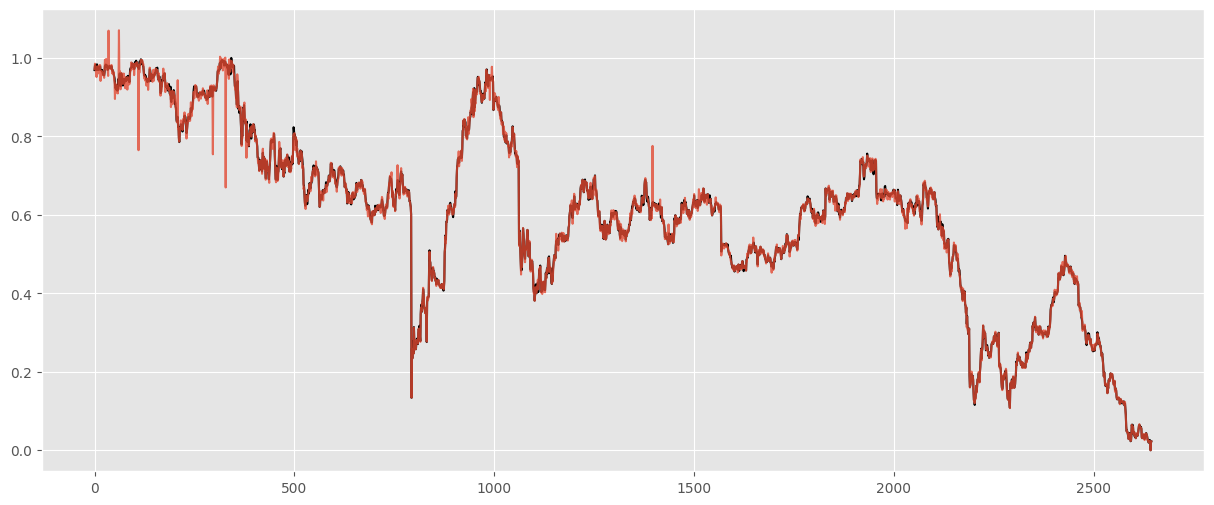

In [195]:
plt.subplots(figsize=(15, 6), dpi=100)

plt.plot(data, color='black')
plt.plot(synth_data[0], alpha=0.8)

plt.show()

In [403]:
nsde_bijection = NSDEFunction(h_dim, data_dim, data_dim)

In [405]:
x, log_pz, log_jacob = nsde_bijection(data_tensor.view(-1, 1))

In [406]:
x.size()

torch.Size([2645, 1])

In [407]:
log_pz

tensor([-1.8100, -1.8201, -1.8226,  ..., -1.1274, -1.1365, -1.1379],
       grad_fn=<SubBackward0>)

In [408]:
log_jacob

tensor([-0.3449, -0.3450, -0.3450,  ..., -0.3397, -0.3399, -0.3399],
       grad_fn=<SumBackward1>)

In [411]:
nsde_bijection.inverse(x)

tensor([[ 0.9687],
        [ 0.9793],
        [ 0.9820],
        ...,
        [-0.0032],
        [ 0.0166],
        [ 0.0196]], grad_fn=<MulBackward0>)

In [410]:
data_tensor

tensor([0.9690, 0.9797, 0.9823,  ..., 0.0000, 0.0196, 0.0226])

In [25]:
# data_train = list(map(lambda x: torch.FloatTensor(x.reshape(-1, 1)), data_train))

In [26]:
# data_train = data_train[:10]

In [187]:
# train_loader = DataLoader(data_train, shuffle=False)

In [ ]:
# epochs = tqdm(range(1000))

# for _ in epochs:
#     for idx in range(len(data_train)):
#         loss = nn.MSELoss()

#         noise = torch.FloatTensor(z_train[idx].reshape(-1, 1))

#         a = torch.sum(drift(noise))
#         b = torch.sum(diffusion(noise))
#         print(a)
#         x = np.zeros(len(noise))
#         dt = 0.1
#         for i in range(len(noise) - 1):
#             x[i+1] = x[i] + a * dt + b * torch.sqrt(dt) * np.random.normal(0, 1)

#         x = Variable(torch.FloatTensor(x.reshape(-1, 1)), requires_grad=True)

#         criterion = loss(data_train[idx], x)

#         optim_drift.zero_grad()
#         optim_diffusion.zero_grad()

#         criterion.backward()

#         optim_drift.step()
#         optim_diffusion.step()

#     epochs.set_description(f'Loss {criterion.item()}')


In [37]:
import candle
import numpy as np
import sdepy
import siglayer

import torch
import torch.nn as nn
import torch.utils.data as torchdata


def gen_data(n_points=100):
    """Generate an Ornstein-Uhlenbeck process."""

    sde = sdepy.ornstein_uhlenbeck_process()
    timeline = np.linspace(0, 1, n_points)
    values = sde(timeline).flatten()
    path = np.c_[timeline, values.tolist()]
    return path.T


def gen_noise(n_points=100):
    """Generate a Brownian motion."""
    
    dt = 1 / np.sqrt(n_points)
    bm = dt * np.r_[0., np.random.randn(n_points - 1).cumsum()]
    timeline = np.linspace(0, 1, n_points)
    return np.c_[timeline, bm].T


def get_signal(num_samples=1000, **kwargs):
    """Generate examples of an Ornstein-Uhlenbeck process."""
    
    paths = np.array([gen_data(**kwargs) for _ in range(num_samples)])
    return torchdata.TensorDataset(torch.tensor(paths, dtype=torch.float))


def get_noise(num_samples=1000, **kwargs):
    """Generate examples of an Brownian motion."""
    
    paths = np.array([gen_noise(**kwargs) for _ in range(num_samples)])
    y = np.zeros_like(paths[:, 0, :-1])
    return torchdata.TensorDataset(torch.tensor(paths, dtype=torch.float), torch.tensor(y, dtype=torch.float))


def scalar_orders(dim, order):
    """The order of the scalar basis elements as one moves along the signature."""
    
    for i in range(order + 1):
        for _ in range(dim ** i):
            yield i


def psi(x, M=4, a=1):
    """Psi function, as defined in the following paper:

    Chevyrev, I. and Oberhauser, H., 2018. Signature moments to
    characterize laws of stochastic processes. arXiv preprint arXiv:1810.10971.

    """

    if x <= M:
        return x
    
    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a
  
    
def normalise_instance(x, order):
    """Normalise signature, following the paper

    Chevyrev, I. and Oberhauser, H., 2018. Signature moments to
    characterize laws of stochastic processes. arXiv preprint arXiv:1810.10971.

    """

    x = torch.cat([torch.tensor([1.], device=x.device), x])

    a = x ** 2
    a[0] -= psi(torch.norm(x))
    
    
    x0 = 1.  # Starting point for Newton-Raphson
    
    moments = torch.tensor([x0 ** (2 * m) for m in range(len(x))], device=x.device)
    polx0 = torch.dot(a, moments)
    
    d_moments = torch.tensor([2 * m * x0 ** (2 * m - 1) for m in range(len(x))], device=x.device)
    d_polx0 = torch.dot(a, d_moments)
    x1 = x0 - polx0 / d_polx0

    if x1 < 0.2:
        x1 = 1.
    
    lambda_ = torch.tensor([x1 ** t for t in scalar_orders(2, order)], device=x.device)

    
    return lambda_ * x


def normalise(x, order):
    """Normalise signature."""

    return torch.stack([normalise_instance(sig, order) for sig in x])


def loss(orig_paths, sig_depth=2, normalise_sigs=True):
    """Loss function is the T statistic defined in
    
    Chevyrev, I. and Oberhauser, H., 2018. Signature moments to
    characterize laws of stochastic processes. arXiv preprint arXiv:1810.10971.

    """
    
    sig = siglayer.Signature(sig_depth)
    orig_signatures = sig(orig_paths)
    if normalise_sigs:
        orig_signatures = normalise(orig_signatures, sig_depth)

    T1 = torch.mean(torch.mm(orig_signatures, orig_signatures.t()))

    def loss_fn(output, *args):
        nonlocal T1, orig_signatures
        T1 = T1.to(device=output.device)
        orig_signatures = orig_signatures.to(device=output.device)
        
        timeline = torch.tensor(np.linspace(0, 1, output.shape[1] + 1), dtype=torch.float32, device=output.device)
        paths = torch.stack([torch.stack([timeline, torch.cat([torch.tensor([0.], device=output.device), path])])
                             for path in output])

        generated_sigs = sig(paths)

        if normalise_sigs:
            generated_sigs = normalise(generated_sigs, sig_depth)

        T2 = torch.mean(torch.mm(orig_signatures, generated_sigs.t()))
        T3 = torch.mean(torch.mm(generated_sigs, generated_sigs.t()))

        return torch.log(T1 - 2 * T2 + T3)

    return loss_fn

ModuleNotFoundError: No module named 'candle'